In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [145]:
df = pd.read_csv("./data.csv", index_col=0)
df = df.convert_dtypes()
df["Hospital admission"] = pd.to_datetime(df["Hospital admission"], format="%d/%m/%Y")
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%d/%m/%Y")
df["Data of death"] = pd.to_datetime(df["Data of death"], errors="coerce", format="%d/%m/%Y")
df["CABG"] = pd.to_datetime(df["CABG"], errors="coerce", format="%d/%m/%Y")
df["Non Fatal AMI (Follow-Up)"] = pd.to_datetime(df["Non Fatal AMI (Follow-Up)"], errors="coerce", format="%d/%m/%Y")
df["Ictus"] = pd.to_datetime(df["Ictus"], errors="coerce", format="%d/%m/%Y")
df["PCI"] = pd.to_datetime(df["PCI"], errors="coerce", format="%d/%m/%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9085 entries, 1 to 9085
Data columns (total 59 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Hospital admission                           9085 non-null   datetime64[ns]
 1   Total cholesterol                            8659 non-null   Int64         
 2   HDL                                          8358 non-null   Int64         
 3   LDL                                          7731 non-null   Int64         
 4   Triglycerides                                8571 non-null   Int64         
 5   Glycemia                                     8608 non-null   Int64         
 6   TSH                                          9085 non-null   string        
 7   T3                                           1844 non-null   string        
 8   fT3                                          9041 non-null   string        
 9

In [62]:
# # test subset AMI in Previous MI
# MI_index = df[df["Acute Myocardial Infarction"]==1].index
# MI = df.loc[MI_index, "Previous Myocardial Infarction"]
# AMI = df.loc[MI_index, "Acute Myocardial Infarction"]
# MI_idx = df[df["Previous Myocardial Infarction"]==1].index
# AMI_idx = df[df["Acute Myocardial Infarction"]==1].index
# print(f"Previous Myocardial Infarction: {len(MI)}")
# print(f"Acute Myocardial Infarction: {len(AMI)}")

# c = 0
# for i in AMI_idx:
#     for j in MI_idx:
#         if i == j:
#             c += 1

# print(c)

# # =============================================
# # test total mortality = OR
# total = df[df["Total mortality"]==1].index
# cvd_idx = df[df["CVD Death"]==1].index
# fatal_idx = df[df["Fatal MI or Sudden death"]==1].index
# unknown_idx = df[df["UnKnown"]==1].index
# accident_idx = df[df["Accident"]==1].index
# suicide_idx = df[df["Suicide"]==1].index

# c = 0
# for i in cvd_idx:
#     for j in fatal_idx:
#         if i == j:
#             c += 1

# print(c)

# # =============================================
# # check if all the number of Data of death == Total mortality
# # this check fails, error patient ID 8211: Total mortality should be = 1
# deaths = df["Data of death"].dropna().index
# assert set(deaths.index) - set(total) == 0

# # check if the date of deaths's are the same of the follow up
# assert (df.loc[deaths, "Follow Up Data"] == df.loc[deaths, "Data of death"]).all()

## Remove all deaths != CVD

In [63]:
# remove all deaths != CVD
total = df[df["Total mortality"]==1].index
cvd_idx = df[df["CVD Death"]==1].index
fatal_idx = df[df["Fatal MI or Sudden death"]==1].index
nonfatal_idx = df["Non Fatal AMI (Follow-Up)"].dropna().index
noncvd_idx = set(total) - set(cvd_idx)
assert len(noncvd_idx) == len(total) - len(cvd_idx)

print(f"Total deaths: {len(total)}")
print(f"Death CVD: {len(cvd_idx)}")
print(f"Death Non-CVD: {len(noncvd_idx)}")
print(f"Death Fatal MI or Sudden: {len(fatal_idx)}")
print(f"Non Fatal AMI (Follow-Up): {len(nonfatal_idx)}")

df_cvd = df.drop(noncvd_idx)
print(f"\nTotal patients: {len(df)}")
print(f"Total patients (after removal of Death Non-CVD): {len(df_cvd)}")

Total deaths: 2811
Death CVD: 1192
Death Non-CVD: 1619
Death Fatal MI or Sudden: 322
Non Fatal AMI (Follow-Up): 352

Total patients: 9085
Total patients (after removal of Death Non-CVD): 7466


## Check distributions for each outcome

Text(0, 0.5, '#Patients')

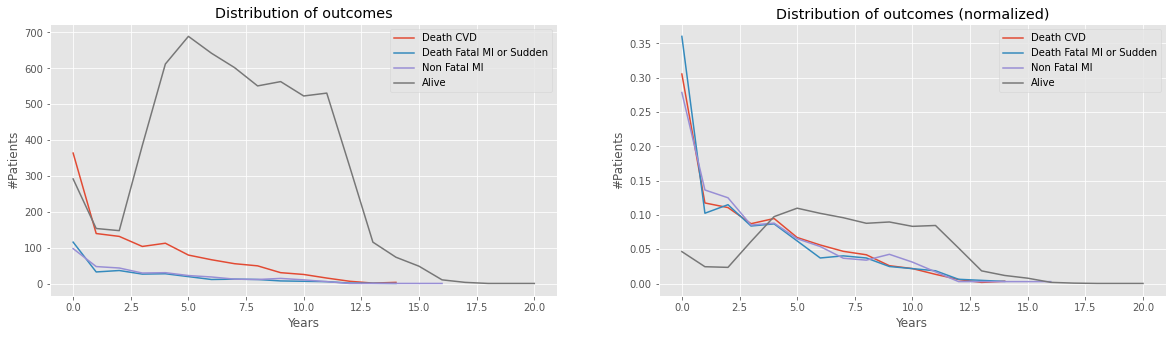

In [143]:
df_diff = df_cvd["Follow Up Data"] - df_cvd["Hospital admission"]
df_diff_nonfatal = df.loc[nonfatal_idx, "Non Fatal AMI (Follow-Up)"] - df.loc[nonfatal_idx, "Hospital admission"]

for i in df_diff.index:
    df_diff[i] = df_diff[i].days // 365
for i in df_diff_nonfatal.index:
    df_diff_nonfatal[i] = df_diff_nonfatal[i].days // 365

df_diff_cvd = df_diff.loc[cvd_idx]
df_diff_fatal = df_diff.loc[fatal_idx]
df_diff_alive = df_diff.drop(cvd_idx)

assert len(df_cvd) == len(df_diff_alive) + len(df_diff_cvd)

# plotting
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
df_diff_cvd.value_counts().sort_index().plot()
df_diff_fatal.value_counts().sort_index().plot()
df_diff_nonfatal.value_counts().sort_index().plot()
df_diff_alive.value_counts().sort_index().plot()
plt.legend(["Death CVD", "Death Fatal MI or Sudden", "Non Fatal MI", "Alive"])
plt.title("Distribution of outcomes")
plt.xlabel("Years")
plt.ylabel("#Patients")

plt.subplot2grid(fig_dims, (0, 1))
df_diff_cvd.value_counts(normalize=True).sort_index().plot()
df_diff_fatal.value_counts(normalize=True).sort_index().plot()
df_diff_nonfatal.value_counts(normalize=True).sort_index().plot()
df_diff_alive.value_counts(normalize=True).sort_index().plot()
plt.legend(["Death CVD", "Death Fatal MI or Sudden", "Non Fatal MI", "Alive"])
plt.title("Distribution of outcomes (normalized)")
plt.xlabel("Years")
plt.ylabel("#Patients")

In [144]:
# save computed difference
df_cvd["Interval (Years)"] = df_diff
df_cvd.to_csv("data_cvd.csv")

In [147]:
df_diff_cvd.value_counts(normalize=True).sort_index()[:5].sum()

0.7156040268456376

In [140]:
# df_deaths = pd.concat([df_diff_cvd, df_diff_fatal, df_diff_nonfatal, df_diff_alive], axis=1)
# df_deaths.columns = ["Death CVD", "Death Fatal MI or Sudden", "NOn Fatal MI", "Alive"]
# df_deaths.plot.hist(bins=20, alpha=0.5)

## Check the percentage of defined features
CVD Death class (df_cvd[df["CVD Death"] == 1].info()), total = 1192 entries
- T3, T4 have ~440 non-null, 36.4%
- Vessels has ~628 non-null, 52.6%

Fatal MI or Sudden death class (df_cvd[df["Fatal MI or Sudden death"] == 1].info()), total = 332
- T3, T4 have ~110 non-null, 33.1%
- Vessels has ~192 non-null, 57.6%

Non Fatal MI class (df.loc[nonfatal_idx].info()), total = 352
- T3, T4 have ~100 non-null, 28.4%
- Vessels has ~273 non-null, 77.5%

Alive class (df_cvd.drop(cvd_idx).info()), total = 6274
- T3, T4 have ~920 non-null, 14.6%
- Vessels has ~3827 non-null, 60.9%

All the patients with only the CVD deaths (df_cvd.info()), total = 7466 entries
- T3, T4 have ~1300 non-null, 17.4%
- Vessels has ~4455 non-null, 59.6%
- LDL has ~6449 non-null, 86.3%

In [41]:
# df_cvd.info()
# df_cvd[df["CVD Death"] == 1].info()
# df_cvd[df["Fatal MI or Sudden death"] == 1].info()
# df.loc[nonfatal_idx].info()
# df_cvd.drop(cvd_idx).info()